<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Pytorch_TensorBoard_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Youtube](https://www.youtube.com/watch?v=RLqsxWaQdHE&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=15)

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
# for writer.add_embedding
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [3]:
%load_ext tensorboard

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data = torchvision.datasets.MNIST('/content',train=True,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST('/content',train=False,
                                        transform=torchvision.transforms.ToTensor(),
                                        download=True)


In [6]:
class CNN(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=6,
                           kernel_size=5,stride=1,padding=2)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5,stride=1)
    self.fc1 = nn.Linear(in_features=400,out_features=80)
    self.fc2 = nn.Linear(in_features=80,out_features=num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0],-1)  #x.shape[0] = batch_size
    x = self.fc1(x)
    x = self.fc2(x)

    return x



In [7]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
batch_sizes = [16,64,128]
learning_rates = [0.001]

In [ ]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] # for writer.add_embedding
for batch_size in batch_sizes:
  print(f'batch_size = {batch_size} ')
  print('- -'*20)
  for learning_rate in learning_rates:
    print(f'learning_rate = {learning_rate} ')
    print('- -'*20)
    step = 0
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)
    model = CNN(in_channels,num_classes).to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),learning_rate)
    writer = SummaryWriter(f'runs/MNIST/batchSize{batch_size}_LR{learning_rate} ')
    example,_ = next(iter(train_loader))
    writer.add_graph(model,example.to(device))
    writer.close()

    for epoch in range(num_epochs):
      running_loss = []
      running_acc = []

      for batch_idx,(images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        pred = model(images)
        loss = criterion(pred,labels)
        running_loss.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _,prediction = torch.max(pred,1)  # ATTENTION : torch.max() has two outputs , index and value
        num_correct = (prediction == labels).sum()
        accuracy = float(num_correct) / float(images.shape[0])
        running_acc.append(accuracy)

        image_grid = torchvision.utils.make_grid(images)

        writer.add_image('mnist_images',image_grid)
        writer.add_histogram('fc2',model.fc2.weight)
        writer.add_scalar('trainig_loss',loss.item(),global_step=step)
        writer.add_scalar('trainig_accuracy',accuracy,global_step=step)

       
        features = images.reshape(images.shape[0], -1)
        class_labels = [classes[label] for label in prediction]

        if batch_idx == 400:
          writer.add_embedding(features,metadata=class_labels,label_img=images,global_step=batch_idx)

        step += 1

        if (batch_idx+1) % 200 == 0 :
          print(f'epoch = {epoch+1}/{num_epochs} , step {step}/{len(train_loader)} ,loss = {loss.item():.4f} ')

    with torch.no_grad():
      n_correct = 0
      losses = 0
      for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        losses += criterion(pred,labels).item()
        _,predicted = torch.max(pred.data,1)
        n_correct += (predicted == labels).sum().item()

    #save the model   
    torch.save(model.state_dict(),f'batchSize{batch_size}_LR{learning_rate}') 

    # (for trainig) writer.add_hparams({'LR':learning_rate, 'batch_size':batch_size},{'accuracy':sum(running_acc)/len(running_acc), 'loss':sum(running_loss)/len(running_loss) })
    writer.add_hparams({'LR':learning_rate, 'batch_size':batch_size},
                       {'test_sccuracy': float(n_correct)/float(len(test_loader)*batch_size), 'loss' : float(losses)/float(len(test_loader))  })

# **add_hparams**(hparam_dict, metric_dict, hparam_domain_discrete=None, run_name=None)

Add a set of hyperparameters to be compared in TensorBoard.

Parameters
hparam_dict (dict) – Each key-value pair in the dictionary is the name of the hyper parameter and it’s corresponding value. The type of the value can be one of bool, string, float, int, or None.

metric_dict (dict) – Each key-value pair in the dictionary is the name of the metric and it’s corresponding value. Note that the key used here should be unique in the tensorboard record. Otherwise the value you added by add_scalar will be displayed in hparam plugin. In most cases, this is unwanted.



```
from torch.utils.tensorboard import SummaryWriter
with SummaryWriter() as w:
    for i in range(5):
        w.add_hparams({'lr': 0.1*i, 'bsize': i},
                      {'hparam/accuracy': 10*i, 'hparam/loss': 10*i})
```
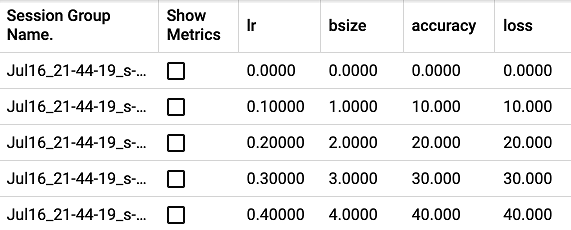


In [ ]:
writer.close()
%tensorboard --logdir=runs

In [ ]:
# load a model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('/content/batchSize16_LR0.001'))